### Multiple Classification(다중 분류 모델)
* 회로 기판이 불량이라면 어떤 유형의 불량인지를 출력하고자 함

#### 1. 환경설정

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

### 관련 파일 root
* 2025-1-DL_PCB/DeepPCB_split/train 내 다음의 폴더들 위치함<br>

test_Defect: 마스크 작업을 완료하여 대응되는 마스크 파일이 있는 이미지만 일단 수집함(시각화로 대응되는지 확인을 위해 사용, 본인 기준이므로 현재 00041000~00041199까지의 200장의 불량 이미지가 들어가있음)<br>

Defect_mask: 위 불량 이미지에 대응되는 마스크 이미지(labelme 통해 생성 -> 추후 형식 변환)<br>

test_temp: 위의 불량 이미지와 동일한 번호의 정상 이미지가 들어 있음(이것도 총 200장)<br>

temp_mask: 정상 이미지에 대한 마스크 파일. 0으로만 채워져 있고 이는 밑에 서술한 코드를 실행시켜 정상 이미지와 대응시켜 제작

### 불량 이미지
* 불량 이미지는 labelme 프로그램을 사용하여 이미지에 1:1 대응되는 마스크 파일을 만들어주어야 한다
* 만든 마스크 파일은 .json 형식이므로 파이썬 코드 등을 통해 png 형식으로 변경해주어야 함

### 정상 이미지?
* 정상 이미지에 대응하는 마스크 또한 만들어줘야 함
* Segmentation 모델은 이미지<-->마스크 쌍을 요구한다.
* 모델이 불량 이미지에 대해 어떤 부분이 불량인지만 학습시키는것보다 정상 모델은 정상이라고도 예측하도록 학습시켜야 함(정상 이미지를 보고도 오인할 가능성이 있기 때문에)
* 정상 마스크의 경우 모든 값을 0으로 만들면 되기 때문에 코드로 작성(코드는 파일 변환 시에만 조정해서 1번 실행, 이후 실행 x)

In [17]:
import os
import numpy as np
from PIL import Image

# 입력: 정상 이미지 폴더 (JPG 형식)
img_dir = "./DeepPCB_split/train/test_temp(0~199)"

# 출력: 마스크 저장 폴더 (PNG 형식)
mask_dir = "./DeepPCB_split/train/temp_mask"
os.makedirs(mask_dir, exist_ok=True)

image_files = os.listdir(img_dir)
created_count = 0

for fname in image_files:
    # 1. 파일이 .jpg/.jpeg 확장자인지 확인
    if fname.lower().endswith(('.jpg', '.jpeg')) and fname.startswith("0004"):
        print(f"✅ 마스크 생성 대상: {fname}")
        
        # 2. 마스크는 같은 번호 + .png 확장자로 저장
        base_name = os.path.splitext(fname)[0]           # ex: '00041000'
        mask_path = os.path.join(mask_dir, base_name + '.png')

        # 3. 640x640 0 마스크 생성 및 저장
        zero_mask = np.zeros((640, 640), dtype=np.uint8)
        Image.fromarray(zero_mask).save(mask_path)

        if os.path.exists(mask_path):
            print(f"  ✅ 저장 완료: {mask_path}")
            created_count += 1
        else:
            print(f"  ❌ 저장 실패: {mask_path}")
    else:
        print(f"⛔ 제외됨: {fname}")

print(f"\n✅ 총 {created_count}개의 PNG 마스크 파일 생성 완료")


✅ 마스크 생성 대상: 00041000_temp.jpg
  ✅ 저장 완료: ./DeepPCB_split/train/temp_mask\00041000_temp.png
✅ 마스크 생성 대상: 00041001_temp.jpg
  ✅ 저장 완료: ./DeepPCB_split/train/temp_mask\00041001_temp.png
✅ 마스크 생성 대상: 00041002_temp.jpg
  ✅ 저장 완료: ./DeepPCB_split/train/temp_mask\00041002_temp.png
✅ 마스크 생성 대상: 00041003_temp.jpg
  ✅ 저장 완료: ./DeepPCB_split/train/temp_mask\00041003_temp.png
✅ 마스크 생성 대상: 00041004_temp.jpg
  ✅ 저장 완료: ./DeepPCB_split/train/temp_mask\00041004_temp.png
✅ 마스크 생성 대상: 00041005_temp.jpg
  ✅ 저장 완료: ./DeepPCB_split/train/temp_mask\00041005_temp.png
✅ 마스크 생성 대상: 00041006_temp.jpg
  ✅ 저장 완료: ./DeepPCB_split/train/temp_mask\00041006_temp.png
✅ 마스크 생성 대상: 00041007_temp.jpg
  ✅ 저장 완료: ./DeepPCB_split/train/temp_mask\00041007_temp.png
✅ 마스크 생성 대상: 00041008_temp.jpg
  ✅ 저장 완료: ./DeepPCB_split/train/temp_mask\00041008_temp.png
✅ 마스크 생성 대상: 00041009_temp.jpg
  ✅ 저장 완료: ./DeepPCB_split/train/temp_mask\00041009_temp.png
✅ 마스크 생성 대상: 00041010_temp.jpg
  ✅ 저장 완료: ./DeepPCB_split/train/temp_mask\000410

#### 2. 데이터 불러오기

✅ 매칭된 이미지-마스크 쌍: 400개


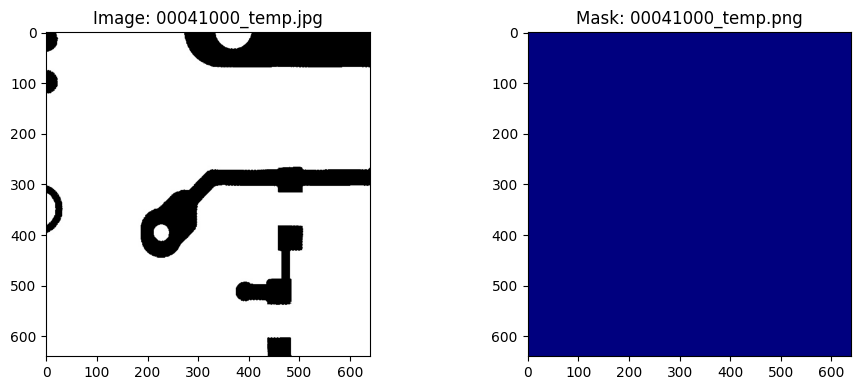

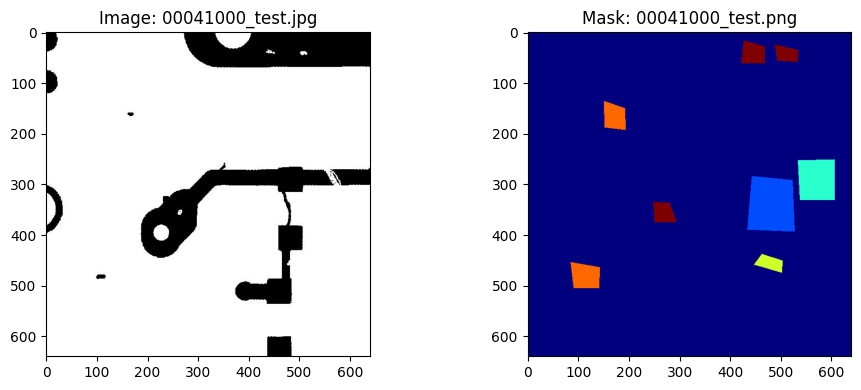

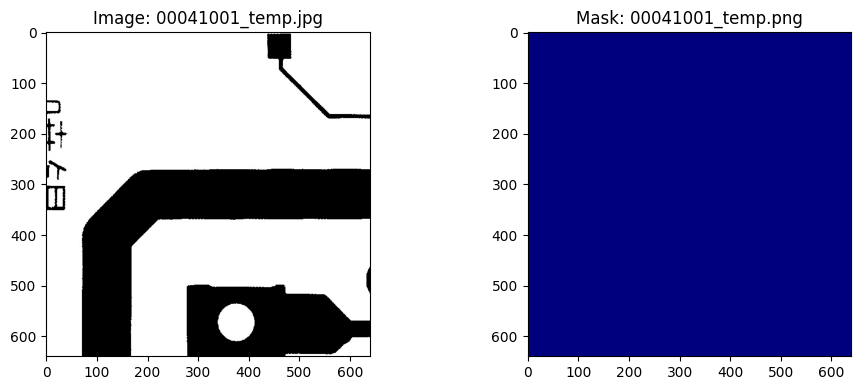

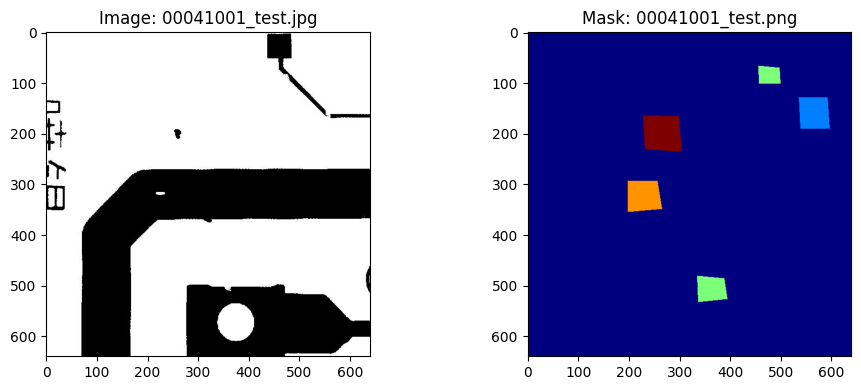

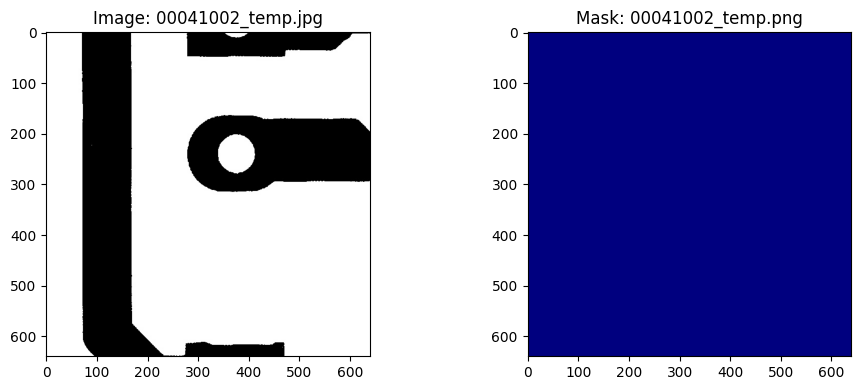

In [20]:
# 경로 설정
image_dir = "./DeepPCB_split/test_img(0~199)"
mask_dir = "./DeepPCB_split/test_mask(0~199)"

# 시각화할 샘플 수
num_samples = 5

# 이미지 확장자 허용 (jpg, jpeg, png 등)
valid_exts = ('.png', '.jpg', '.jpeg')

# 매칭 리스트 생성
matched_files = []
for fname in sorted(os.listdir(image_dir)):
    if fname.lower().endswith(valid_exts):
        base_name = os.path.splitext(fname)[0]
        mask_path = os.path.join(mask_dir, base_name + ".png")
        if os.path.exists(mask_path):
            matched_files.append((os.path.join(image_dir, fname), mask_path))
        else:
            print(f"❌ 마스크 없음: {base_name}.png")

print(f"✅ 매칭된 이미지-마스크 쌍: {len(matched_files)}개")

# 시각화
for i, (img_path, mask_path) in enumerate(matched_files[:num_samples]):
    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")  # grayscale 마스크

    # 이미지, 마스크 크기 맞춤 (선택)
    if img.size != mask.size:
        mask = mask.resize(img.size, resample=Image.NEAREST)

    # 시각화
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Image: {os.path.basename(img_path)}")
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.title(f"Mask: {os.path.basename(mask_path)}")
    plt.imshow(mask, cmap='jet')

    plt.tight_layout()
    plt.show()


In [9]:
# 데이터 분할(학습 / 검증 데이터로 나누기)
from sklearn.model_selection import train_test_split
print("전체 데이터 수:", images.shape[0])

# train:validation = 80:20으로 분할
X_train, X_val, y_train, y_val = train_test_split(
    images,           # 입력 이미지들 (N, 256, 256, 3)
    masks_cat,        # 원-핫 마스크들 (N, 256, 256, num_classes)
    test_size=0.2,    # 20%는 검증용으로 사용
    random_state=42,  # 결과 재현을 위한 시드값
    shuffle=True      # 데이터 섞기 (불량 클래스 고르게 분포)
)

# 결과 확인
print(f"✅ 학습 이미지 수: {X_train.shape[0]}")
print(f"✅ 검증 이미지 수: {X_val.shape[0]}")

전체 데이터 수: 200
✅ 학습 이미지 수: 160
✅ 검증 이미지 수: 40


In [10]:
def build_unet(input_shape=(256, 256, 3), num_classes=6):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.UpSampling2D()(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.UpSampling2D()(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.UpSampling2D()(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c9)

    model = models.Model(inputs, outputs)
    return model

# 모델 생성 및 컴파일
unet_model = build_unet(input_shape=(256, 256, 3), num_classes=num_classes)
unet_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# 구조 확인
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [11]:
# 모델 학습
history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=10
)

Epoch 1/10
20/20 [==============================] - 12s 193ms/step - loss: 26.8546 - accuracy: 0.9189 - val_loss: 0.2586 - val_accuracy: 0.9694
Epoch 2/10
20/20 [==============================] - 4s 181ms/step - loss: 0.2447 - accuracy: 0.9675 - val_loss: 0.2064 - val_accuracy: 0.9694
Epoch 3/10
20/20 [==============================] - 4s 180ms/step - loss: 0.2064 - accuracy: 0.9675 - val_loss: 0.1897 - val_accuracy: 0.9694
Epoch 4/10
20/20 [==============================] - 4s 182ms/step - loss: 0.1966 - accuracy: 0.9675 - val_loss: 0.1821 - val_accuracy: 0.9694
Epoch 5/10
20/20 [==============================] - 4s 182ms/step - loss: 0.1882 - accuracy: 0.9675 - val_loss: 0.1741 - val_accuracy: 0.9694
Epoch 6/10
20/20 [==============================] - 4s 181ms/step - loss: 0.1806 - accuracy: 0.9675 - val_loss: 0.1804 - val_accuracy: 0.9694
Epoch 7/10
20/20 [==============================] - 4s 182ms/step - loss: 0.1805 - accuracy: 0.9675 - val_loss: 0.1601 - val_accuracy: 0.9694
Epoc

1/1 [==============================] - 1s 1s/step


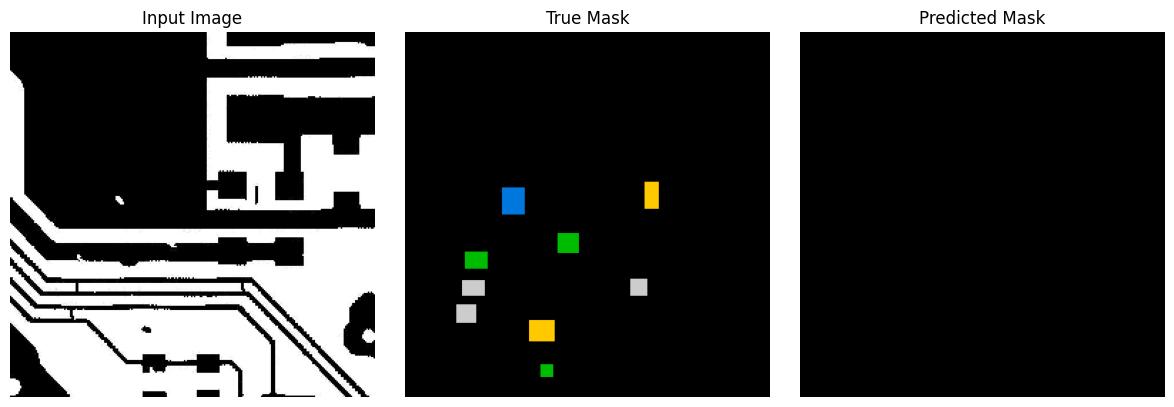

1/1 [==============================] - 0s 17ms/step


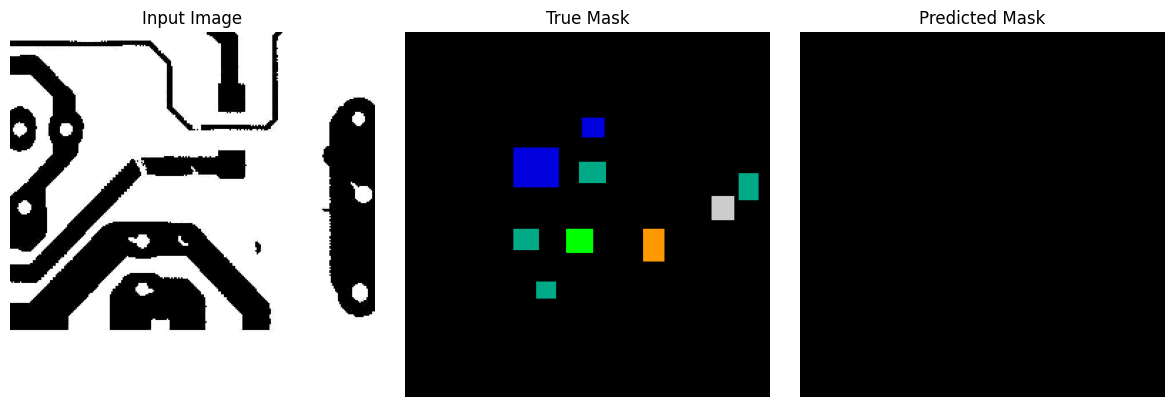

1/1 [==============================] - 0s 16ms/step


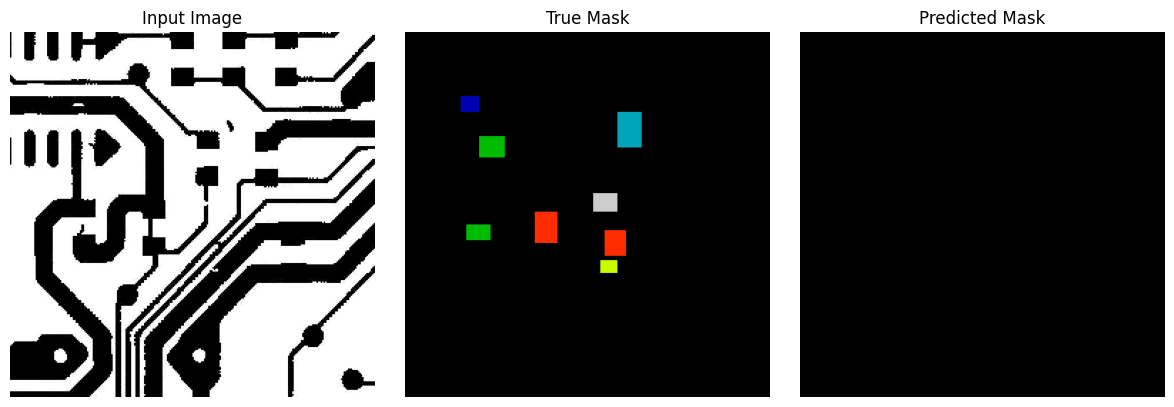

1/1 [==============================] - 0s 17ms/step


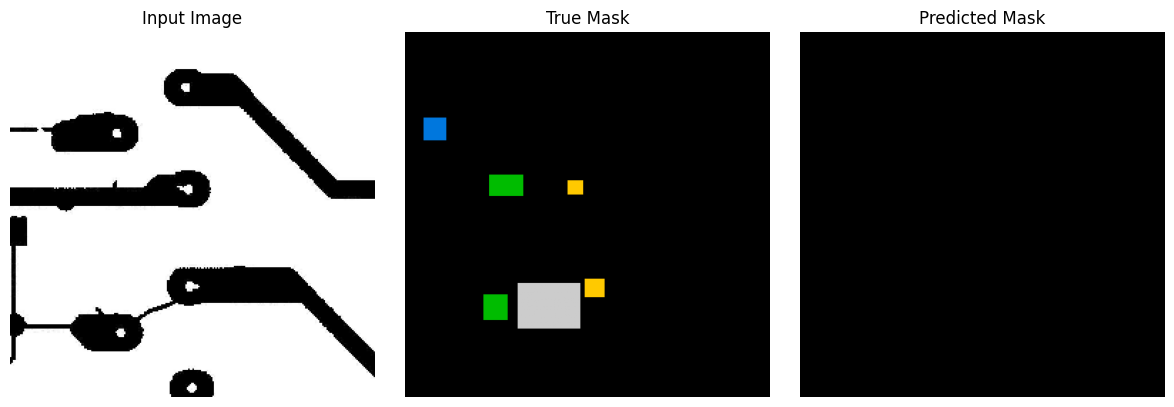

1/1 [==============================] - 0s 15ms/step


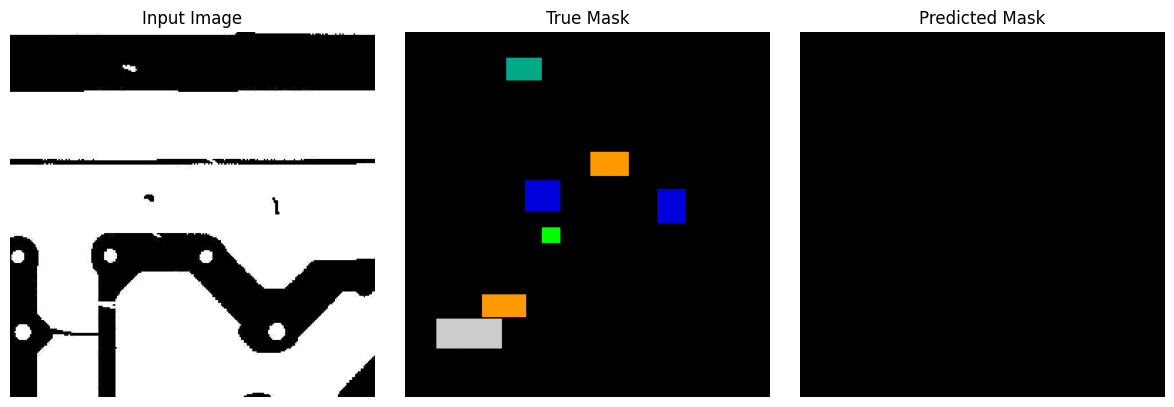

In [12]:

# 하나 또는 일부 샘플에 대해 예측
def visualize_prediction(model, images, masks, num_samples=30):
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i in indices:
        image = np.expand_dims(images[i], axis=0)  # [1, H, W, 3]
        pred = model.predict(image)
        pred_mask = np.argmax(pred.squeeze(), axis=-1)  # [H, W]
        true_mask = np.argmax(masks[i], axis=-1)        # [H, W]

        # 시각화
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='nipy_spectral')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='nipy_spectral')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

visualize_prediction(unet_model, X_val, y_val, num_samples=5)  